In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from core import bw_color_palette
import numpy as np
from tqdm import tqdm
import textwrap
from joblib import Parallel, delayed

In [3]:
plt.rcParams['font.size'] = 7
plt.rcParams['svg.fonttype'] = 'none'

In [4]:
def assign_predicted_category(row):
    if row['defense_system_protein']:
        return 'Defense homolog in expected system'
    elif row['defense_homolog']:
        return 'Defense homolog in new context'
    elif row['q_cov'] > 0.5:
        return 'Remote defense homolog'
    else:
        return 'Predicted novel defense gene'

In [5]:
predicted_defense_df = pd.read_csv('../data/ecoli/interim/predicted_defense_df.csv')
hhpred_results = pd.read_csv('../data/ecoli/interim/ecoli_putative_novel_hhdb_domains.csv')

In [6]:
filtered_defense_df = (predicted_defense_df
                       .sort_values('log_odds', ascending=False)
                       .groupby('cluster_id')
                       .head(1))
filtered_defense_df['accession_stub'] = filtered_defense_df['product_accession'].str.split('.', expand=True)[0]

In [7]:
hhpred_results['q_ali_len'] = hhpred_results['qend'] - hhpred_results['qstart']
remote_defense_homologs = (hhpred_results[hhpred_results['hit_name'].str.contains('~') &
                                          (hhpred_results['Prob'] > 50)]
                           .sort_values('q_ali_len', ascending=False)
                           .groupby('query')
                           .head(1)
                           .merge(filtered_defense_df[['accession_stub', 'product_accession', 'product_length']].drop_duplicates(), 
                                  how='left', left_on='query', right_on='accession_stub'))
remote_defense_homologs['q_cov'] = remote_defense_homologs['q_ali_len']/remote_defense_homologs['product_length']

In [8]:
merged_predictions = (predicted_defense_df
                      .drop(columns='predicted_category')
                      .merge(
    remote_defense_homologs[['product_accession', 'hit_name', 'q_cov', 'Prob']], how='left', 
                                                   on='product_accession'))
merged_predictions['q_cov'] = merged_predictions['q_cov'].fillna(0)
merged_predictions['predicted_category'] = merged_predictions.apply(assign_predicted_category, axis=1)
merged_predictions['predicted_category'] = pd.Categorical(merged_predictions['predicted_category'], 
                                                          categories=['Defense homolog in expected system', 
                                                                      'Defense homolog in new context',
                                                                      'Remote defense homolog',
                                                                      'Predicted novel defense gene'])

In [9]:
cluster_unique_category = (merged_predictions.sort_values('predicted_category')
                           .groupby('cluster_id')
                           .head(1)
                           [['cluster_id', 'predicted_category']])

In [10]:
cluster_unique_category['predicted_category'].value_counts()

predicted_category
Predicted novel defense gene          1374
Defense homolog in new context        1082
Defense homolog in expected system     925
Remote defense homolog                 550
Name: count, dtype: int64

In [11]:
all_merged_predictions = (predicted_defense_df.drop(columns='predicted_category')
                          .merge(cluster_unique_category[['cluster_id', 'predicted_category']], 
                                 how='inner', on='cluster_id'))

In [12]:
all_merged_predictions['predicted_category'].value_counts()

predicted_category
Defense homolog in expected system    66877
Predicted novel defense gene          24746
Defense homolog in new context        18979
Remote defense homolog                13230
Name: count, dtype: int64

In [13]:
genomes = all_merged_predictions['assembly'].drop_duplicates()
len(genomes)

3000

In [14]:
sample_range = [int(x) for x in np.linspace(1, 3_000, num=50)]
n_boot = 50
n_def_cluster_list = list()
for n in tqdm(sample_range):
    for boot in range(n_boot):
        sampled_genomes = genomes.sample(n=n, random_state=boot)
        sampled_def_df = all_merged_predictions[all_merged_predictions['assembly'].isin(sampled_genomes)]
        unique_sampled_def_df = (sampled_def_df
                                 .groupby('cluster_id')
                                 .head(1))
        n_def_clusters = (unique_sampled_def_df['predicted_category']
                          .value_counts()
                          .reset_index())
        n_def_clusters['n_genomes'] = n
        n_def_clusters['boot'] = boot
        n_def_cluster_list.append(n_def_clusters)
cat_n_def_cluster = pd.concat(n_def_cluster_list)

100%|██████████| 50/50 [01:23<00:00,  1.67s/it]


In [15]:
agg_n_def_cluster = (cat_n_def_cluster.groupby(['n_genomes', 'predicted_category'])
                     .agg({'count': 'mean'})
                     .reset_index())

In [16]:
agg_n_def_cluster['predicted_category'] = pd.Categorical(agg_n_def_cluster['predicted_category'], 
                                                         categories=['Defense homolog in expected system', 
                                                                     'Defense homolog in new context', 
                                                                     'Remote defense homolog', 
                                                                     'Predicted novel defense gene'])

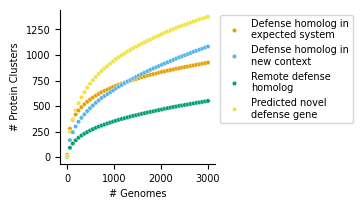

In [17]:
plt.subplots(figsize=(2, 2))
sns.scatterplot(data=agg_n_def_cluster, x='n_genomes', y='count', hue='predicted_category',
              palette=bw_color_palette[:4], s=10)#, 
                #hue_order=['Predicted novel defense gene',
                #           'Defense homolog in new context', 
                #           'Defense homolog in expected system',
                #           'Remote defense homolog'])
sns.despine()
# Adjust legend
legend = plt.legend(loc="upper left", bbox_to_anchor=(1,1))
handles, labels = legend.get_texts(), [text.get_text() for text in legend.get_texts()]
wrapped_labels = [textwrap.fill(label, 20) for label in labels]
for text, wrapped_label in zip(handles, wrapped_labels):
    text.set_text(wrapped_label)
# Other plot attributes
plt.ylabel('# Protein Clusters')
plt.xlabel('# Genomes')
plt.savefig('../figures/ecoli_predicted_category_per_genome.svg', dpi=300, bbox_inches='tight')

(0.0, 750.0)

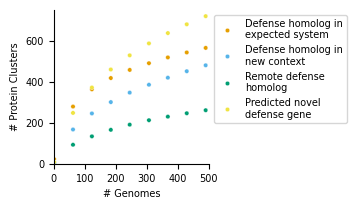

In [18]:
plt.subplots(figsize=(2, 2))
sns.scatterplot(data=agg_n_def_cluster, x='n_genomes', y='count', hue='predicted_category',
              palette=bw_color_palette[:4], s=10)#, 
                #hue_order=['Predicted novel defense gene',
                #           'Defense homolog in new context', 
                #           'Defense homolog in expected system',
                #           'Remote defense homolog'])
sns.despine()
# Adjust legend
legend = plt.legend(loc="upper left", bbox_to_anchor=(1,1))
handles, labels = legend.get_texts(), [text.get_text() for text in legend.get_texts()]
wrapped_labels = [textwrap.fill(label, 20) for label in labels]
for text, wrapped_label in zip(handles, wrapped_labels):
    text.set_text(wrapped_label)
# Other plot attributes
plt.ylabel('# Protein Clusters')
plt.xlabel('# Genomes')
plt.xlim(0, 500)
plt.ylim(0, 750)

In [21]:
cluster_unique_novel = (merged_predictions.sort_values('predicted_category')
                           .groupby('cluster_id')
                           .head(1)
                        .query("predicted_category == 'Predicted novel defense gene'"))

In [23]:
%%time 
all_predictions = pd.read_csv('../data/ecoli/processed/ecoli_predictions_annot.csv')

<timed exec>:1: DtypeWarning: Columns (7,21,25,27,28) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 59.7 s, sys: 7.11 s, total: 1min 6s
Wall time: 1min 7s


In [24]:
cluster_unique_novel.to_csv('../data/ecoli/processed/unique_novel_defense.csv', index=False)
all_predictions[['assembly']].drop_duplicates().to_csv('../data/ecoli/processed/ecoli_genomes.csv', index=False)

In [14]:
cluster_stats = (all_predictions.groupby(['cluster_id'])
                  .agg(n = ('product_accession', 'nunique'), 
                       max_defensive=('predicted_defensive', 'max'),
                       frac_defensive = ('predicted_defensive', 'mean'))
                  .reset_index())
cluster_stats = cluster_stats[cluster_stats['n'] > 2]

In [15]:
(cluster_stats.loc[cluster_stats['max_defensive'], 'frac_defensive'] == 1).mean()

0.6164960866947622

In [16]:
(cluster_stats.loc[cluster_stats['max_defensive'], 'frac_defensive'] > 0.5).mean()

0.8169777242624925

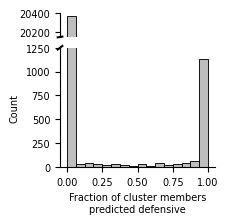

In [17]:
f, (ax_top, ax_bottom) = plt.subplots(ncols=1, nrows=2, sharex=True, 
                                      gridspec_kw={'hspace':0.15}, 
                                      figsize=(2, 2), 
                                      height_ratios=[1,5])
sns.histplot(data=cluster_stats, x='frac_defensive', color='darkgrey', ax=ax_bottom)
sns.histplot(data=cluster_stats, x='frac_defensive', color='darkgrey', ax=ax_top)
ax_top.set_ylim(20400-1_250*1/5, 20400)   
ax_bottom.set_ylim(0,1_250)
sns.despine(ax=ax_bottom)
sns.despine(ax=ax_top, bottom=True)

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax_top.transAxes, color='k', clip_on=False)
ax_top.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax_top.xaxis.set_visible(False)
ax_top.set_ylabel('')

kwargs.update(transform=ax_bottom.transAxes)  # switch to the bottom axes
ax_bottom.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

ax_bottom.set_xlabel("Fraction of cluster members\n"
           "predicted defensive")
plt.savefig('../figures/frac_defensive.svg', bbox_inches='tight')

In [27]:
all_predictions_merged = (all_predictions.merge(all_merged_predictions[['protein_context_id', 'predicted_category']], 
                                                how='left', on='protein_context_id'))


In [28]:
all_predictions_merged.to_csv('../data/processed/ecoli_predictions_annot_v2.csv', index=False)


In [30]:
all_merged_predictions.to_csv('../data/processed/ecoli_predicted_defense_annot.csv', index=False)


Compare the number of defense systems identified by DefenseFinder vs DefensePredictor

In [4]:
all_predictions_merged = pd.read_csv('../data/processed/ecoli_predictions_annot_v2.csv')

/state/partition1/slurm_tmp/27693011.0.0/ipykernel_1517681/3398725057.py:1: DtypeWarning: Columns (7,21,25,27,28,31) have mixed types. Specify dtype option on import or set low_memory=False.
  all_predictions_merged = pd.read_csv('../data/processed/ecoli_predictions_annot_v2.csv')


In [5]:
def count_systems(assembly, assembly_df, dp_operon_dist):
    n_df_systems = assembly_df['defense_system'].nunique()
    assembly_df = assembly_df.sort_values(['genomic_accession', 'start']).reset_index(drop=True)
    operon = 0
    prev_end = None
    prev_strand = None
    operon_list = list()
    for _, row in assembly_df.iterrows():
        if prev_end is not None:
            if (prev_strand != row['strand']) or (abs(prev_end - row['start']) > dp_operon_dist):
                operon += 1
        operon_list.append(operon)
        prev_end = row['end']
        prev_strand = row['strand']
    assembly_df['operon'] = operon_list
    assembly_pred_defense = assembly_df.query('predicted_defensive')
    n_dp_systems = assembly_pred_defense['operon'].nunique()
    system_count_dict = {'assembly': assembly, 
                         '# DefenseFinder Systems': n_df_systems, 
                         '# DefensePredictor Systems': n_dp_systems}
    return system_count_dict
    

In [6]:
dp_operon_dist = 30
system_count_list = Parallel(n_jobs=40)(delayed(count_systems)(assembly, assembly_df, dp_operon_dist) for assembly, assembly_df in tqdm(all_predictions_merged.groupby('assembly')))

100%|██████████| 3000/3000 [01:46<00:00, 28.22it/s]


In [7]:
system_count_df = pd.DataFrame(system_count_list)
system_count_df = system_count_df.rename(columns={'# DefenseFinder Systems': 'DefenseFinder', 
                                                  '# DefensePredictor Systems': 'DefensePredictor'})

In [8]:
system_count_df[['DefenseFinder', 'DefensePredictor']].mean(axis=0)

DefenseFinder        4.504000
DefensePredictor    28.303333
dtype: float64

In [9]:
28.3/4.5

6.288888888888889

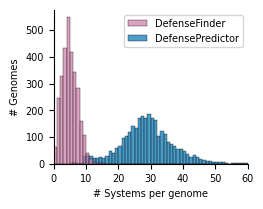

In [12]:
plt.subplots(figsize=(2.5, 2))
sns.histplot(data=system_count_df, binwidth=1, palette=[bw_color_palette[6],bw_color_palette[4]], alpha=0.7, 
             linewidth=0.25)
plt.xlim(0, 60)
sns.despine()
plt.xlabel('# Systems per genome')
plt.ylabel('# Genomes')
plt.savefig('../figures/system_per_genome_comparison.svg', dpi=300, bbox_inches='tight')

In [29]:
n_dp_systems

27

In [30]:
n_df_systems

9

In [19]:
assembly_df.iloc[1370:1390,:]

,protein_context_id,beaker_prediction,# feature,class,assembly,assembly_unit,seq_type,chromosome,genomic_accession,start,end,strand,product_accession,non-redundant_refseq,related_accession,name,symbol,GeneID,locus_tag,feature_interval_length,product_length,attributes,log_odds,predicted_defensive,assembly_stub,defense_homolog_name,defense_homolog,defense_system_gene,defense_system,defense_system_protein,cluster_id,predicted_category
1370,NP_309414.1|NC_002695.2|1439160|+,5.325981e-05,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,1439160,1439798,+,NP_309414.1,WP_000502842.1,NaN,hypothetical protein,ybdM,913299.0,ECs_1387,639,212.0,NaN,-9.840275,False,GCF_000008865,NaN,False,NaN,NaN,False,WP_113264684.1,NaN
1371,NP_309415.1|NC_002695.2|1439877|+,1.513212e-05,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,1439877,1440146,+,NP_309415.1,WP_000226520.1,NaN,transcriptional regulator PchD,pchD,913436.0,ECs_1388,270,89.0,NaN,-11.098676,False,GCF_000008865,NaN,False,NaN,NaN,False,WP_097409192.1,NaN
1372,NP_309416.1|NC_002695.2|1440167|+,8.660283e-02,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,1440167,1440811,+,NP_309416.1,WP_001333354.1,NaN,hypothetical protein,NaN,912545.0,ECs_1389,645,214.0,NaN,-2.355838,False,GCF_000008865,NaN,False,NaN,NaN,False,WP_196613092.1,NaN
1373,YP_009502605.1|NC_002695.2|1441127|+,6.220782e-08,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,1441127,1441627,+,YP_009502605.1,WP_001303904.1,NaN,glycolate transporter,NaN,62675990.0,ECs_5709,501,166.0,NaN,-16.592785,False,GCF_000008865,NaN,False,NaN,NaN,False,YP_009502605.1,NaN
1374,NP_309420.1|NC_002695.2|1441811|+,1.505451e-10,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,1441811,1442236,+,NP_309420.1,WP_000422760.1,NaN,transposase,NaN,913807.0,ECs_1393,426,141.0,NaN,-22.616758,False,GCF_000008865,NaN,False,NaN,NaN,False,WP_058652552.1,NaN
1375,NP_309421.1|NC_002695.2|1442536|-,4.243261e-05,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,1442536,1442718,-,NP_309421.1,WP_000282125.1,NaN,hypothetical protein,NaN,914450.0,ECs_1394,183,60.0,NaN,-10.067551,False,GCF_000008865,NaN,False,NaN,NaN,False,WP_072661607.1,NaN
1376,NP_309422.1|NC_002695.2|1443047|+,7.797213e-01,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,1443047,1443919,+,NP_309422.1,WP_001069769.1,NaN,GTP-binding protein,yfjP,914784.0,ECs_1395,873,290.0,NaN,1.264043,False,GCF_000008865,Eleos__LeoBC,True,NaN,NaN,False,WP_072646411.1,NaN
1377,NP_309423.1|NC_002695.2|1444291|+,1.029978e-06,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,1444291,1447140,+,NP_309423.1,WP_000820483.1,NaN,AidA-I family adhesin,NaN,912599.0,ECs_1396,2850,949.0,NaN,-13.785972,False,GCF_000008865,NaN,False,NaN,NaN,False,WP_112045057.1,NaN
1378,NP_309424.1|NC_002695.2|1447251|+,1.000000e+00,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,1447251,1449635,+,NP_309424.1,WP_000544679.1,NaN,hypothetical protein,NaN,912553.0,ECs_1397,2385,794.0,NaN,18.770328,True,GCF_000008865,NaN,False,NaN,NaN,False,WP_230894503.1,Predicted novel defense gene
1379,NP_309425.1|NC_002695.2|1449632|+,8.760395e-01,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,1449632,1450537,+,NP_309425.1,WP_000203541.1,NaN,chemotaxis protein,NaN,912390.0,ECs_1398,906,301.0,NaN,1.955448,False,GCF_000008865,NaN,False,NaN,NaN,False,WP_282646665.1,NaN


In [18]:
pd.set_option('display.max_columns', 50)
assembly_pred_defense

,protein_context_id,beaker_prediction,# feature,class,assembly,assembly_unit,seq_type,chromosome,genomic_accession,start,end,strand,product_accession,non-redundant_refseq,related_accession,name,symbol,GeneID,locus_tag,feature_interval_length,product_length,attributes,log_odds,predicted_defensive,assembly_stub,defense_homolog_name,defense_homolog,defense_system_gene,defense_system,defense_system_protein,cluster_id,predicted_category
1,NP_052605.1|NC_002127.1|971|-,0.999905,CDS,with_protein,GCF_000008865.2,Primary Assembly,plasmid,pOSAK1,NC_002127.1,971,1351,-,NP_052605.1,WP_000710826.1,NaN,hypothetical protein,NaN,1789661.0,pOSAK1_02,381,126.0,NaN,9.264595,True,GCF_000008865,RnlAB__RnlB,True,RnlAB__RnlB,UserReplicon_RnlAB_1,True,WP_079849606.1,Defense homolog in new context
2,NP_052606.1|NC_002127.1|1348|-,1.000000,CDS,with_protein,GCF_000008865.2,Primary Assembly,plasmid,pOSAK1,NC_002127.1,1348,2388,-,NP_052606.1,WP_000068433.1,NaN,hypothetical protein,NaN,1789663.0,pOSAK1_03,1041,346.0,NaN,15.788754,True,GCF_000008865,RnlAB__RnlA,True,RnlAB__RnlA,UserReplicon_RnlAB_1,True,WP_000068433.1,Defense homolog in expected system
361,NP_308317.1|NC_002695.2|311992|+,0.999999,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,311992,312408,+,NP_308317.1,WP_000082144.1,NaN,hypothetical protein,NaN,914389.0,ECs_0290,417,138.0,NaN,13.513344,True,GCF_000008865,Lamassu-Fam__LmuA_effector_Mrr,True,NaN,NaN,False,NP_308317.1,Defense homolog in new context
362,NP_308318.1|NC_002695.2|312381|+,1.000000,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,312381,312998,+,NP_308318.1,WP_001303996.1,NaN,hypothetical protein,NaN,914390.0,ECs_0291,618,205.0,NaN,16.784052,True,GCF_000008865,Lamassu-Fam__LmuA_effector_hypothetical,True,NaN,NaN,False,NP_308318.1,Defense homolog in new context
372,NP_308331.1|NC_002695.2|322025|-,0.999890,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,322025,322981,-,NP_308331.1,WP_000205213.1,NaN,hypothetical protein,NaN,914403.0,ECs_0304,957,318.0,NaN,9.113908,True,GCF_000008865,NaN,False,NaN,NaN,False,WP_000205214.1,Predicted novel defense gene
943,YP_009502596.1|NC_002695.2|1001387|-,0.999896,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,1001387,1001773,-,YP_009502596.1,WP_000539519.1,NaN,addiction module toxin RelE,NaN,62675955.0,ECs_5400,387,128.0,NaN,9.171997,True,GCF_000008865,NaN,False,NaN,NaN,False,WP_000539519.1,Remote defense homolog
990,NP_308989.1|NC_002695.2|1047549|+,0.999583,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,1047549,1049207,+,NP_308989.1,WP_000599788.1,NaN,OLD family ATP-dependent endonuclease,ybjD,917699.0,ECs_0962,1659,552.0,NaN,7.781680,True,GCF_000008865,PARIS_I__AAA_15,True,NaN,NaN,False,WP_252491735.1,Defense homolog in new context
1378,NP_309424.1|NC_002695.2|1447251|+,1.000000,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,1447251,1449635,+,NP_309424.1,WP_000544679.1,NaN,hypothetical protein,NaN,912553.0,ECs_1397,2385,794.0,NaN,18.770328,True,GCF_000008865,NaN,False,NaN,NaN,False,WP_230894503.1,Predicted novel defense gene
1480,NP_309531.2|NC_002695.2|1543707|+,0.999533,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,1543707,1544222,+,NP_309531.2,WP_000559928.1,NaN,hypothetical protein,NaN,912890.0,ECs_1504,516,171.0,NaN,7.669079,True,GCF_000008865,NaN,False,NaN,NaN,False,WP_000559928.1,Predicted novel defense gene
1898,NP_309980.1|NC_002695.2|1935126|+,1.000000,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,1935126,1936277,+,NP_309980.1,WP_001100703.1,NaN,DNA methylase,NaN,917152.0,ECs_1953,1152,383.0,NaN,19.907459,True,GCF_000008865,Druantia_II__DruM,True,RM_Type_II__Type_II_MTases,UserReplicon_RM_Type_II_2,True,WP_045145125.1,Defense homolog in new context


In [15]:
assembly_df

,protein_context_id,beaker_prediction,# feature,class,assembly,assembly_unit,seq_type,chromosome,genomic_accession,start,...,log_odds,predicted_defensive,assembly_stub,defense_homolog_name,defense_homolog,defense_system_gene,defense_system,defense_system_protein,cluster_id,predicted_category
0,NP_052604.1|NC_002127.1|413|+,1.087770e-08,CDS,with_protein,GCF_000008865.2,Primary Assembly,plasmid,pOSAK1,NC_002127.1,413,...,-18.336551,False,GCF_000008865,NaN,False,NaN,NaN,False,WP_011178361.1,NaN
1,NP_052605.1|NC_002127.1|971|-,9.999053e-01,CDS,with_protein,GCF_000008865.2,Primary Assembly,plasmid,pOSAK1,NC_002127.1,971,...,9.264595,True,GCF_000008865,RnlAB__RnlB,True,RnlAB__RnlB,UserReplicon_RnlAB_1,True,WP_079849606.1,Defense homolog in new context
2,NP_052606.1|NC_002127.1|1348|-,9.999999e-01,CDS,with_protein,GCF_000008865.2,Primary Assembly,plasmid,pOSAK1,NC_002127.1,1348,...,15.788754,True,GCF_000008865,RnlAB__RnlA,True,RnlAB__RnlA,UserReplicon_RnlAB_1,True,WP_000068433.1,Defense homolog in expected system
3,NP_052608.1|NC_002128.1|2589|+,1.612680e-08,CDS,with_protein,GCF_000008865.2,Primary Assembly,plasmid,pO157,NC_002128.1,2589,...,-17.942784,False,GCF_000008865,NaN,False,NaN,NaN,False,WP_248841111.1,NaN
4,NP_052609.1|NC_002128.1|3675|+,1.392247e-08,CDS,with_protein,GCF_000008865.2,Primary Assembly,plasmid,pO157,NC_002128.1,3675,...,-18.089762,False,GCF_000008865,NaN,False,NaN,NaN,False,WP_123905914.1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5150,NP_313383.1|NC_002695.2|5492933|+,1.865169e-10,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,5492933,...,-22.402499,False,GCF_000008865,NaN,False,NaN,NaN,False,WP_097449755.1,NaN
5151,NP_313384.1|NC_002695.2|5493622|+,1.744917e-08,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,5493622,...,-17.863974,False,GCF_000008865,NaN,False,NaN,NaN,False,WP_001219602.1,NaN
5152,NP_313385.1|NC_002695.2|5495104|+,1.709208e-09,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,5495104,...,-20.187236,False,GCF_000008865,NaN,False,NaN,NaN,False,WP_000920328.1,NaN
5153,NP_313386.1|NC_002695.2|5496516|-,7.602380e-10,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,5496516,...,-20.997390,False,GCF_000008865,NaN,False,NaN,NaN,False,WP_097449755.1,NaN


In [10]:
n_dp_systems = 

9

In [8]:
assembly_df

,protein_context_id,beaker_prediction,# feature,class,assembly,assembly_unit,seq_type,chromosome,genomic_accession,start,...,log_odds,predicted_defensive,assembly_stub,defense_homolog_name,defense_homolog,defense_system_gene,defense_system,defense_system_protein,cluster_id,predicted_category
14048849,NP_313289.1|NC_002695.2|5376769|+,1.000000e+00,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,5376769,...,30.445231,True,GCF_000008865,DISARM_1__drmMI,True,RM_Type_IIG__Type_IIG,UserReplicon_RM_Type_IIG_3,True,WP_072686171.1,Defense homolog in expected system
14048850,NP_311640.1|NC_002695.2|3602324|-,1.000000e+00,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,3602324,...,26.598992,True,GCF_000008865,Cas__cse2gr11_I-E_8,True,Cas__cse2gr11_I-E_1,UserReplicon_CAS_Class1-Subtype-I-E_1,True,WP_260733685.1,Defense homolog in new context
14048851,NP_313334.2|NC_002695.2|5439734|-,1.000000e+00,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,5439734,...,22.556966,True,GCF_000008865,RM__Type_I_MTases,True,RM__Type_I_MTases,UserReplicon_RM_Type_I_1,True,WP_337972644.1,Defense homolog in expected system
14048852,NP_311638.1|NC_002695.2|3600500|-,1.000000e+00,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,3600500,...,22.191423,True,GCF_000008865,Cas__cas5_I-E_13,True,Cas__cas5_I-E_3,UserReplicon_CAS_Class1-Subtype-I-E_1,True,WP_137521658.1,Defense homolog in new context
14048853,NP_311641.1|NC_002695.2|3602857|-,1.000000e+00,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,3602857,...,21.915363,True,GCF_000008865,Cas__cas8e_I-E_2,True,Cas__cas8e_I-E_1,UserReplicon_CAS_Class1-Subtype-I-E_1,True,WP_001753005.1,Defense homolog in new context
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14053999,NP_311605.1|NC_002695.2|3570300|-,5.465690e-14,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,3570300,...,-30.537701,False,GCF_000008865,NaN,False,NaN,NaN,False,WP_000115222.1,NaN
14054000,NP_313159.1|NC_002695.2|5233414|-,3.966199e-14,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,5233414,...,-30.858383,False,GCF_000008865,NaN,False,NaN,NaN,False,WP_137441575.1,NaN
14054001,NP_308512.1|NC_002695.2|514704|-,2.866821e-14,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,514704,...,-31.182988,False,GCF_000008865,NaN,False,NaN,NaN,False,WP_047204449.1,NaN
14054002,NP_308599.1|NC_002695.2|630228|+,2.024172e-14,CDS,with_protein,GCF_000008865.2,Primary Assembly,chromosome,NaN,NC_002695.2,630228,...,-31.531031,False,GCF_000008865,NaN,False,NaN,NaN,False,WP_135436347.1,NaN


#### Side analysis

In [114]:
ecor_comp_list = list()
n=69
n_boot = 1000
for boot in tqdm(range(n_boot)):
    sampled_genomes = genomes.sample(n=n, random_state=boot)
    sampled_def_df = all_merged_predictions[all_merged_predictions['assembly'].isin(sampled_genomes)]
    n_def_clusters = (sampled_def_df.groupby('predicted_category')
                      .agg(n_unique_clusters=('cluster_id', 'nunique'))
                      .reset_index())
    n_def_clusters['n_genomes'] = n
    n_def_clusters['boot'] = boot
    ecor_comp_list.append(n_def_clusters)
ecor_comp_df = pd.concat(ecor_comp_list)

100%|██████████| 1000/1000 [00:33<00:00, 29.82it/s]


In [115]:
ecor_comp_df['predicted_category'] = pd.Categorical(ecor_comp_df['predicted_category'], 
                                                         categories=['Defense homolog in expected system', 
                                                                     'Defense homolog in new context', 
                                                                     'Remote defense homolog', 
                                                                     'Predicted novel defense gene'])

In [116]:
ecor_hit_category = pd.DataFrame([{'predicted_category': 'Defense homolog in new context', 
                                   'n_unique_clusters': 335},
                                  {'predicted_category': 'Predicted novel defense gene', 
                                   'n_unique_clusters': 217}, 
                                  {'predicted_category': 'Defense homolog in expected system', 
                                   'n_unique_clusters': 115}, 
                                  {'predicted_category': 'Remote defense homolog', 
                                   'n_unique_clusters': 80}])
ecor_hit_category['predicted_category'] = pd.Categorical(ecor_hit_category['predicted_category'], 
                                                         categories=['Defense homolog in expected system', 
                                           'Defense homolog in new context',
                                           'Remote defense homolog', 
                                           'Predicted novel defense gene'])


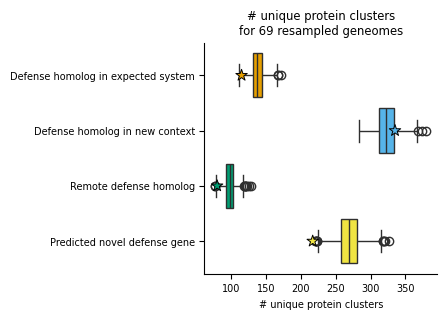

In [124]:
plt.subplots(figsize=(3,3))
sns.boxplot(data=ecor_comp_df, y='predicted_category', x='n_unique_clusters', 
            hue='predicted_category', palette=bw_color_palette[:4], saturation=1, zorder=0)
sns.scatterplot(data=ecor_hit_category, y='predicted_category', x='n_unique_clusters', 
            hue='predicted_category', palette=bw_color_palette[:4], s=75, marker='*', 
                edgecolor='black', legend=False, zorder=1)
sns.despine()
plt.title('')
plt.xlabel('# unique protein clusters')
plt.ylabel('')
plt.title('# unique protein clusters\nfor 69 resampled geneomes')
plt.savefig('../figures/unique_defense_protein_clusters_resampled.png', dpi=300, bbox_inches='tight')

In [66]:
(ecor_comp_df.groupby('predicted_category')
 .agg({'n_unique_clusters': ['min', 'max', 'mean', 'median', 'std']}))

n_unique_clusters                        
                                                 min  max     mean median   
predicted_category                                                          
Defense homolog in expected system               111  172  137.570  137.0  \
Defense homolog in new context                   283  380  322.912  322.0   
Remote defense homolog                            77  128   98.248   98.5   
Predicted novel defense gene                     221  327  269.614  269.0   

                                               
                                          std  
predicted_category                             
Defense homolog in expected system  10.064213  
Defense homolog in new context      16.070735  
Remote defense homolog               7.938988  
Predicted novel defense gene        16.845557

In [20]:
cat_n_def_cluster['predicted_category'] = pd.Categorical(cat_n_def_cluster['predicted_category'], 
                                                         categories=['Defense homolog in expected system', 
                                                                     'Defense homolog in new context', 
                                                                     'Remote defense homolog', 
                                                                     'Predicted novel defense gene'])

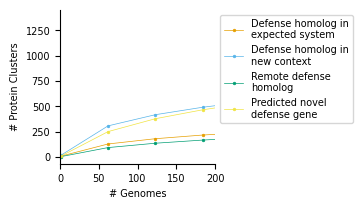

In [23]:
plt.subplots(figsize=(2, 2))
sns.pointplot(data=cat_n_def_cluster, x='n_genomes', y='n_unique_clusters', hue='predicted_category',
              palette=bw_color_palette[:4], n_boot=100, native_scale=True, markersize=2, linewidth=0.5)#, 
                #hue_order=['Predicted novel defense gene',
                #           'Defense homolog in new context', 
                #           'Defense homolog in expected system',
                #           'Remote defense homolog'])
sns.despine()
# Adjust legend
legend = plt.legend(loc="upper left", bbox_to_anchor=(1,1))
handles, labels = legend.get_texts(), [text.get_text() for text in legend.get_texts()]
wrapped_labels = [textwrap.fill(label, 20) for label in labels]
for text, wrapped_label in zip(handles, wrapped_labels):
    text.set_text(wrapped_label)
# Other plot attributes
plt.ylabel('# Protein Clusters')
plt.xlabel('# Genomes')
plt.xlim(0, 200)
plt.savefig('../figures/ecoli_predicted_category_per_genome.svg', dpi=300, bbox_inches='tight')

How many in each cluster are predicted to be defensive?

In [ ]:
all_merged_predictions

,protein_context_id,beaker_prediction,# feature,class,assembly,assembly_unit,seq_type,chromosome,genomic_accession,start,...,log_odds,predicted_defensive,assembly_stub,defense_homolog_name,defense_homolog,defense_system_gene,defense_system,defense_system_protein,cluster_id,predicted_category
0,WP_001568552.1|NZ_JAIHLJ010000004.1|11426|+,1.000000,CDS,with_protein,GCF_020668315.1,Primary Assembly,unplaced scaffold,NaN,NZ_JAIHLJ010000004.1,11426,...,29.469973,True,GCF_020668315,Thoeris_I__ThsA_new_grand,True,NaN,NaN,False,WP_040088523.1,Defense homolog in new context
1,WP_001362421.1|NZ_CP018252.2|3661488|+,1.000000,CDS,with_protein,GCF_001890285.2,Primary Assembly,chromosome,NaN,NZ_CP018252.2,3661488,...,28.713248,True,GCF_001890285,Thoeris_I__ThsA_new_grand,True,NaN,NaN,False,WP_040088523.1,Defense homolog in new context
2,WP_001362421.1|NZ_JH590523.1|29169|+,1.000000,CDS,with_protein,GCF_000241995.1,Primary Assembly,unplaced scaffold,NaN,NZ_JH590523.1,29169,...,28.796573,True,GCF_000241995,Thoeris_I__ThsA_new_grand,True,NaN,NaN,False,WP_040088523.1,Defense homolog in new context
3,WP_001362421.1|NZ_JAHCEQ010000018.1|1939|+,1.000000,CDS,with_protein,GCF_022322145.1,Primary Assembly,unplaced scaffold,NaN,NZ_JAHCEQ010000018.1,1939,...,28.801571,True,GCF_022322145,Thoeris_I__ThsA_new_grand,True,NaN,NaN,False,WP_040088523.1,Defense homolog in new context
4,WP_001362421.1|NZ_MIWU01000035.1|14705|+,1.000000,CDS,with_protein,GCF_001749205.1,Primary Assembly,unplaced scaffold,NaN,NZ_MIWU01000035.1,14705,...,28.815265,True,GCF_001749205,Thoeris_I__ThsA_new_grand,True,NaN,NaN,False,WP_040088523.1,Defense homolog in new context
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123827,WP_139008450.1|NZ_AIGN01000051.1|5654|-,0.999990,CDS,with_protein,GCF_000249955.1,Primary Assembly,unplaced scaffold,NaN,NZ_AIGN01000051.1,5654,...,11.477096,True,GCF_000249955,NaN,False,NaN,NaN,False,WP_139008450.1,Predicted novel defense gene
123828,WP_233407392.1|NZ_JADWRG010000267.1|1|+,0.999936,CDS,with_protein,GCF_021354195.1,Primary Assembly,unplaced scaffold,NaN,NZ_JADWRG010000267.1,1,...,9.655019,True,GCF_021354195,RM_Type_III__Type_III_REases,True,NaN,NaN,False,WP_233407392.1,Defense homolog in new context
123829,WP_236937793.1|NZ_NLXB01000011.1|26135|+,0.999999,CDS,with_protein,GCF_002512085.1,Primary Assembly,unplaced scaffold,NaN,NZ_NLXB01000011.1,26135,...,13.449269,True,GCF_002512085,NaN,False,NaN,NaN,False,WP_236937793.1,Predicted novel defense gene
123830,WP_242811559.1|NZ_NMAS01000036.1|39836|+,0.999999,CDS,with_protein,GCF_002535585.1,Primary Assembly,unplaced scaffold,NaN,NZ_NMAS01000036.1,39836,...,13.883647,True,GCF_002535585,Lamassu-Fam__LmuA_effector_Sir2,True,NaN,NaN,False,WP_242811559.1,Defense homolog in new context


In [27]:
predicted_defense_ids = all_merged_predictions.loc[all_merged_predictions['predicted_defensive'], 
                                                   'product_accession'].drop_duplicates()


In [28]:
accession_clusters = pd.read_table('../data/ecoli/interim/seq_clusters.txt', names=['cluster_id', 'product_accession'])

In [29]:
accession_clusters['predicted_defensive'] = (accession_clusters['product_accession']
                                             .isin(predicted_defense_ids))


In [31]:
cluster_defensive_summary = (accession_clusters.groupby('cluster_id')
                             .agg(total=('product_accession', 'count'), 
                                  predicted_defensive=('predicted_defensive', 'sum'))
                             .reset_index())
cluster_defensive_summary['frac_defensive'] = cluster_defensive_summary['predicted_defensive']/cluster_defensive_summary['total']
                             

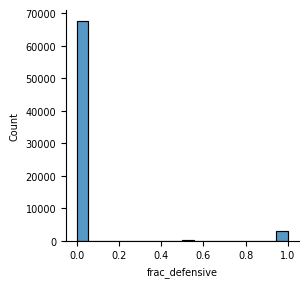

In [33]:
plt.subplots(figsize=(3,3))
sns.histplot(data=cluster_defensive_summary, x='frac_defensive')
sns.despine()

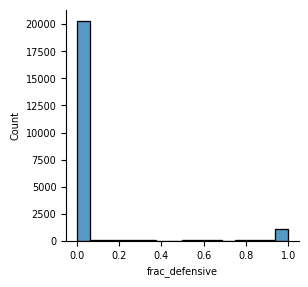

In [36]:
plt.subplots(figsize=(3,3))
sns.histplot(data=cluster_defensive_summary.query('total > 2'), x='frac_defensive')
sns.despine()

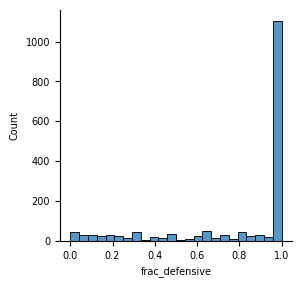

In [37]:
plt.subplots(figsize=(3,3))
sns.histplot(data=cluster_defensive_summary.query('(frac_defensive > 0) & (total > 2)'), x='frac_defensive')
sns.despine()

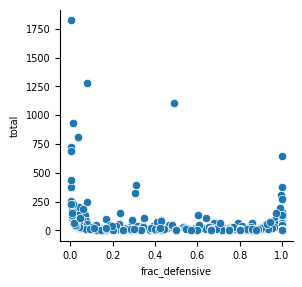

In [35]:
plt.subplots(figsize=(3,3))
sns.scatterplot(data=cluster_defensive_summary.query('frac_defensive > 0'), 
                x='frac_defensive', y='total')
sns.despine()

In [ ]:
all_predictions

In [38]:
cluster_defensive_summary.query('(frac_defensive > 0.4) & (total > 1000)')

,cluster_id,total,predicted_defensive,frac_defensive
20219,WP_096986558.1,1109,544,0.490532


In [39]:
%%time 
all_predictions = pd.read_csv('../data/ecoli/processed/all_predictions.csv')


<timed exec>:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 49.9 s, sys: 6.34 s, total: 56.2 s
Wall time: 56.7 s


In [41]:
yehi_homologs = accession_clusters.loc[accession_clusters['cluster_id'] == 'WP_096986558.1', 
                                       'product_accession']


In [47]:
yehi_predictions = all_predictions[all_predictions['product_accession'].isin(yehi_homologs)].copy()


In [48]:
import numpy as np

In [49]:
yehi_predictions['log_odds'] = np.log(yehi_predictions['beaker_prediction']/
                                      (1-yehi_predictions['beaker_prediction']))

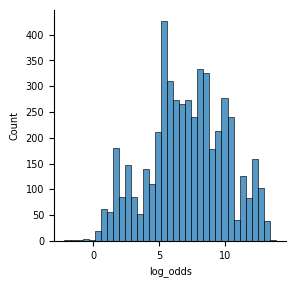

In [50]:
plt.subplots(figsize=(3,3))
sns.histplot(data=yehi_predictions, x='log_odds')
sns.despine()

In [ ]:
sns.his

In [25]:
accession_assemblies

,product_accession,assembly
0,WP_000002126.1,GCF_002231995
1,WP_000002284.1,GCF_002231995
2,WP_000002448.1,GCF_002231995
3,WP_000002541.1,GCF_002231995
4,WP_000002772.1,GCF_002231995
...,...,...
14082834,WP_353933616.1,GCF_001248665
14082835,WP_353933618.1,GCF_001248665
14082836,WP_353933620.1,GCF_001248665
14082837,WP_353933621.1,GCF_001248665


In [23]:
assembly_clusters_df = (accession_assemblies.merge(accession_clusters, how='inner', on='product_accession')
                        [['cluster_id', 'assembly']].drop_duplicates())

In [24]:
assembly_clusters_df

,cluster_id,assembly
0,WP_042099480.1,GCF_002231995
1,WP_042099480.1,GCF_002015965
2,WP_042099480.1,GCF_002546975
3,WP_042099480.1,GCF_037153635
4,WP_042099480.1,GCF_003318875
...,...,...
14082834,WP_353933616.1,GCF_001248665
14082835,WP_337083813.1,GCF_001248665
14082836,WP_353933620.1,GCF_001248665
14082837,WP_113773413.1,GCF_001248665


In [18]:
(~all_merged_predictions['predicted_defensive']).sum()

3822

### Old analyses